# Compare trans-eQTL p-values with and without non-EUR samples

- toc: true 
- badges: true
- comments: true


## Background

Trans-eQTLs can be confounded by population substructure. To get an idea, I am comparing the p-values for trans-eQTLs obtained from all samples against the p-values obtained from only European samples. 

Path to all data files

In [1]:
#collapse-hide
teqtl_all_dir = '/usr/users/sbanerj/trans-eQTL/gtex_v8_tejaas_trans_eQTLs_20200309/protein_coding_lncRNA_fixed_gamma_alt-haa-spl-pan-wb_combined_cut5e-8'
teqtl_eur_dir = '/cbscratch/sbanerj/trans-eqtl/dev-pipeline/gtex_v8_EUR_202006'

tissue_file = 'gtex/tissue_table.txt'
json_file = 'gtex/gtex_v8_metadata.json'
nsample_file = "gtex/tissue_nsamples.txt"

Python libraries

In [2]:
#collapse-hide
import os
import numpy as np
import json
import collections
import matplotlib.pyplot as plt
from utils import mpl_stylesheet
mpl_stylesheet.banskt_presentation(fontfamily = 'latex-clearsans', fontsize = 18, colors = 'banskt', dpi = 72)
from utils import utils

Read metadata for our trans-eQTLs

In [3]:
#collapse-hide
tshorts, tfulls, tstrings = utils.read_tissues(tissue_file)
with open(json_file) as instream:
    gtex_meta = json.load(instream)
tissue_colors = dict()
tissue_names = dict()
tissue_nsamples = dict()

for tshort, tfull, tstring in zip(tshorts, tfulls, tstrings):
    if tshort in tshorts:
        tissue_names[tshort] = tstring
        tissue_colors[tshort] = "#" + gtex_meta[tfull]["colorHex"]
        
tissue_nsamples = dict()
with open(nsample_file, 'r') as instream:
    for line in instream:
        tshort = line.strip().split()[0].strip()
        tissue_nsamples[tshort] = int(line.strip().split()[1].strip())
        
brain_tissues = ['bam', 'ban', 'bca', 'bceh', 'bce', 'bco', 'bfr', 'bhi', 'bhy', 'bnu', 'bpu', 'bsp', 'bsu']
altsb_tissues = ['haa', 'pan', 'spl', 'wb']

Define some functions to read results

In [4]:
def read_transeqtls(filename):
    idcol = 0
    chrcol = 1
    bpcol = 2
    pvcol = 7
    rsidlist = list()
    chrmlist = list()
    bplist   = list()
    pvallist = list()
    with open(filename, 'r') as instream:
        next(instream)
        for line in instream:
            linesplit = line.strip().split()
            rsid = linesplit[idcol]
            chrm = int(linesplit[chrcol])
            bppos = int(linesplit[bpcol])
            pval = float(linesplit[pvcol])
            rsidlist.append(rsid)
            chrmlist.append(chrm)
            bplist.append(bppos)
            pvallist.append(pval)
    return rsidlist, chrmlist, pvallist, bplist

Read the results for trans-eQTLs

In [5]:
#collapse-hide
whichtissues = ['as', 'ms', 'sse']

RES_FIELDS = ['vall', 'veur']
class CompareRes(collections.namedtuple('_CompareRes', RES_FIELDS)):
    __slots__ = ()

res = dict()
for tshort in whichtissues:
    res[tshort] = list()
    teqtl_all_file = os.path.join(teqtl_all_dir, tshort, 'trans_eqtls_ldpruned.txt')
    teqtl_eur_file = os.path.join(teqtl_eur_dir, tshort,
                                  'tejaas/raw_std/permnull_sb0.006_knn30',
                                  'all_lead_transeqtl_rr.txt'
                                 )
    allvarids, allchrms, allpvals, allbppos = read_transeqtls(teqtl_all_file)
    eurvarids, eurchrms, eurpvals, eurbppos = read_transeqtls(teqtl_eur_file)
    for i, varid in enumerate(allvarids):
        if varid in eurvarids:
            j = eurvarids.index(varid)
            res[tshort].append(CompareRes(vall = allpvals[i], veur = eurpvals[j]))

## Plots
 * Compare $-\log_{10} (p)$ with and without non-EUR samples

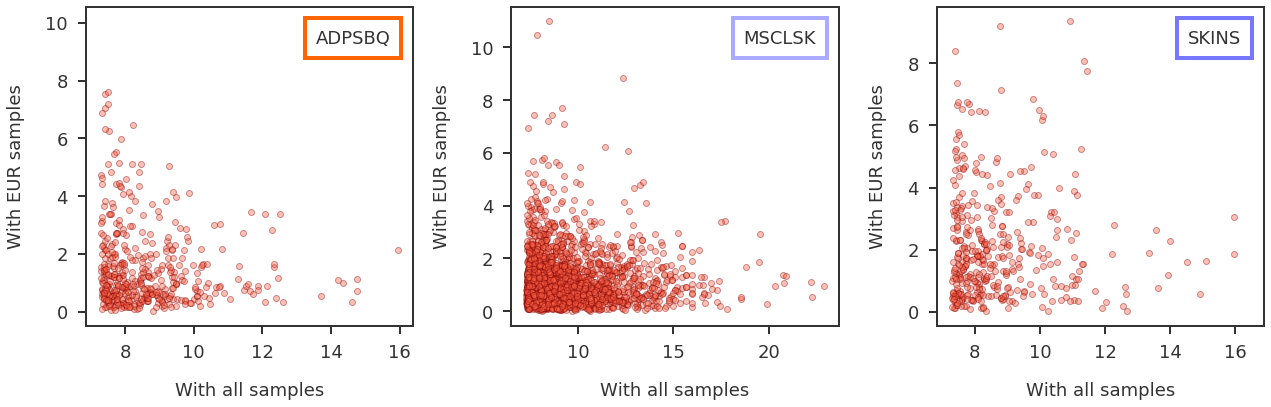

In [6]:
#collapse-hide
fig = plt.figure(figsize = (18, 6))
ax = list([0, 0, 0])
ax[0] = fig.add_subplot(131)
ax[1] = fig.add_subplot(132)
ax[2] = fig.add_subplot(133)

for i, tshort in enumerate(whichtissues):
    xvals = [-np.log10(x.vall) for x in res[tshort]]
    yvals = [-np.log10(x.veur) for x in res[tshort]]
    ax[i].scatter(xvals, yvals, alpha = 0.4, facecolor = 'tomato', edgecolor = 'maroon')
    ax[i].set_xlabel('With all samples')
    ax[i].set_ylabel('With EUR samples')
    boxprops = dict(boxstyle='square, pad=0.6', facecolor='white', 
                    edgecolor=tissue_colors[tshort], linewidth = 4)
    ax[i].text(0.93, 0.93, tissue_names[tshort],
               transform=ax[i].transAxes, verticalalignment='top', horizontalalignment = 'right', bbox=boxprops)
    #ax[i].set_xlim([8, 16])
    #ax[i].set_ylim([0, 16])

plt.tight_layout()
plt.show()

Load $p$ values for `all samples`, `EUR samples` and `simulations`

In [7]:
#collapse-hide
tshort = 'sse'
teqtl_eur_file = os.path.join(teqtl_eur_dir, tshort,
                              'tejaas/raw_std/permnull_sb0.006_knn30/chr21',
                              'rr.txt')
teqtl_all_file = os.path.join('/scratch/sbanerj/trans-eqtl/dev-pipeline/gtex_v8_202003', tshort,
                              'tejaas/raw_std/permnull_sb0.1_knn30/chr21',
                              'rr.txt'
                             )
teqtl_sim_file = os.path.join('/cbscratch/sbanerj/trans-eqtl/simulation',
                              '12639_450_10_800_30_100_100_0.01_0.5_0.0_1.0_0.6_4.0_0.1_20_0.02/sim001',
                              'tejaas/permnull_sb0.01/raw_knn30/peer0',
                              'rr.txt'
                             )
eurvarids, eurchrms, eurpvals, eurbppos = read_transeqtls(teqtl_eur_file)
allvarids, allchrms, allpvals, allbppos = read_transeqtls(teqtl_all_file)
simvarids, simchrms, simpvals, simbppos = read_transeqtls(teqtl_sim_file)

 * Look at the $p$ value distribution without non-EUR samples, with all samples and simulations

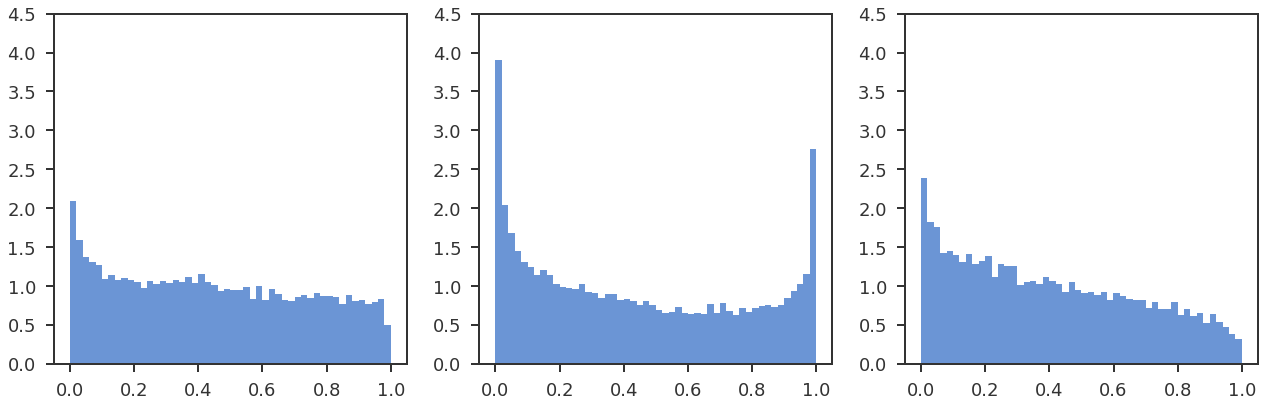

In [8]:
#collapse-hide
fig = plt.figure(figsize = (18,6))
ax1 = fig.add_subplot(131)
ax2 = fig.add_subplot(132)
ax3 = fig.add_subplot(133)
ax1.hist(eurpvals, alpha = 0.7, bins = 50, lw = 0, density = True)
ax2.hist(allpvals, alpha = 0.7, bins = 50, lw = 0, density = True)
ax3.hist(simpvals, alpha = 0.7, bins = 50, lw = 0, density = True)
for ax in [ax1, ax2, ax3]:
    ax.set_ylim([0, 4.5])
plt.tight_layout()
plt.show()